<a href="https://colab.research.google.com/github/reganmeloche/ML-from-scratch/blob/main/svm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SVM

Given a set of training examples for a binary class, SVM (Support Vector Machine) builds a model that classifies new examples - it is a non-probabilistic binary linear classifier (Logistic Regression is probabilistic)

For a given classification, we may have a hyperplane (e.g. a line) that separates the points, but there may be multiple possibilities for hyperplanes - how do we find the best one?

The points that the separating hyperplanes touch are the "support vectors". The SVM classifier is, in a sense, *defined* by the support vectors. 

In this notebook, we will discuss some important theory behind how SVM works, and build our own simple SVM classifier from scratch. We will then test it on a simple automatically generated dataset and compare with SKlearn's SVM implementation.


Sources:
- https://www.youtube.com/watch?v=efR1C6CvhmE&ab_channel=StatQuestwithJoshStarmer
- https://towardsdatascience.com/support-vector-machine-introduction-to-machine-learning-algorithms-934a444fca47
- https://www.svm-tutorial.com/2014/11/svm-understanding-math-part-1/
- https://towardsdatascience.com/implementing-svm-from-scratch-784e4ad0bc6a

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import math

%matplotlib inline

## Theory

So how do we find the hyperplane?

We will find optimal weights and intercept of the hyperplane by minimizing some cost function. 

The shortest distance between observations and our separating hyperplane is called the **margin**
- For example, in a 1D problem, we just put a point halfway between the two threshold observations (the support vectors). The margin is as large as it could be in this case.
- In 2D, the hyperplane will be a 1D line and becomes more difficult.
- We want to make the margin as big as possible (gives breathing room between classes, and will work best on new instances of data)

Ideally there are no points within the margins, and in this case we would use the maximal marginal classifier. But this may not be realistic when dealing with real data, as there may be some outliers in each of the classes. In this case, we must allow for misclassifications, and use a **soft-margin classifier**. We will focus on the simpler maximal margin classifier case.

We can think of the general process as selecting two hyperplanes that separate the data and then maximizing their distance. For this tutorial, we will assume the data is linearly separable, and use the maximal margin classifier.


### Deriving the margin equation

The margin for the data below is separated by the two blue lines.

The equation for our hyperplane H can be thought of as a linear combination: $ y = w_1 x_1 + w_2 x_2 + b = w^T x + b$

An important property to note is that the vector w is perpendicular to the hyperplane.

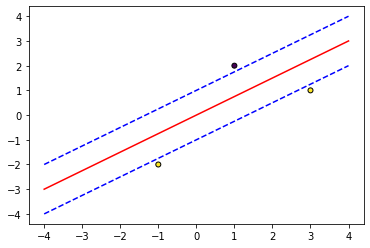

In [ ]:
X = np.array([[1,2], [3,1], [-1,-2]])
Y = [-1,1,1]

plt.scatter(X[:, 0], X[:, 1], marker="o", c=Y, s=25, edgecolor="k")

x = np.linspace(-4, 4, 100)
plt.plot(x, 0.75*x, color='Red')

plt.plot(x, 0.75*x+1, color='Blue', linestyle='dashed')
plt.plot(x, 0.75*x-1, color='Blue', linestyle='dashed')

plt.show()


Our two other planes that cross our support vectors can be defines as follows:
- H0: for class $y=-1$, $w^T x  +b \leq -1$
- H1: for class $y=1$, $w^T x + b \geq 1$

Let's imagine $x_0$ is a point on H0. We'll say m is the perpendicular distance from x0 to H1 (aka the margin). So we want to find the value of m.

Since w is perpendicular, we can use that and do some clever math
- First, we take the unit vector of w: $u = \frac{w} {\|w\|}$
- This vector has length 1. So we need to ask how much we scale this by to get from $x_0$ to H1. The answer is m, so we get the vector k: $k = mu$
- k is perpendicular to H1 and $\|k\| = m$

Now we have $x_0 + k = z_0$, where $z_0$ is a point on H1.

Now we do a bit more algebra to simplify:
$$w \cdot z_0 + b = 1$$

$$ w \cdot (x_0 + m \frac{w} {|w\|}) + b = 1 $$

$$ w \cdot x_0 + m \frac{w \cdot w} {\|w\|}) + b = 1 $$

$$ w \cdot x_0 + m {\|w\|} + b = 1 $$

Since $w \cdot x_0 + b = 1$, we get:

$$ -1 = 1 - m{\|w\|} $$

$$ m = \frac{2}{\|w\|} $$

So we have a way to compute the margin. It's fairly straightforward - if we increase it, then m is small. Bigger norm means smaller margin. Smaller norm means bigger margin.

Our goal is to minimize this, but we are subject to certain constraints, namely:
$$ y_i = -1: w \cdot x_i + b \leq -1  $$
$$ y_i = 1: w \cdot x_i + b \geq 1  $$

We can re-organize both of these into a single statement:
$$ y_i(w \cdot x_i + b) \geq 1 $$



So our goal is as follows: Minimize $\|w\|$ subject to We can re-organize both of these into a single statement:
$$ y_i(w \cdot x_i + b) \geq 1 $$

### Hinge Loss


We want to incorporate these two ideas into a single equation, which we will then optimize. 

We can use the hinge loss function as a simple loss function for the maximum margin classification:

$$ L = max(0, 1 - y_i(w \cdot x_i + b) ) $$

Note the following:
- $y_i$ will be either 1 or -1
- $ w \cdot x_i + b$ could be any number and represents the prediction for a given $x_i$. If the actual $y_i$ value is 1, then we want $ w \cdot x_i + b \geq 1$.
- If it is greater than 1, then the hinge loss function results in 0. 
- If it is less than 1, then the hinge loss function punishes it with a high loss value. Our goal is to minimize this.

To visualize, let's replace $w \cdot x_i + b $ with t to get $ L = max(0, 1 - y_i \cdot t ) $

We define a simple hinge loss function below and show the resulting graph for the case where $y_i = 1$

So anything that correctly predicts a high value ( > 1) receives  loss of 0. If the prediction is less than 1, then it is incorrect, and is punished with a high loss value.

In [ ]:
def hinge_loss(y, t):
    return max(0, 1 - (y*t))

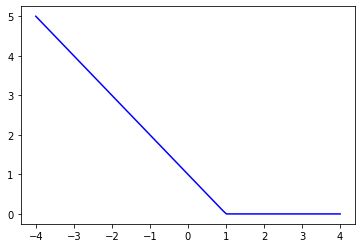

In [ ]:
x = np.linspace(-4, 4, 100)
x2 = [hinge_loss(1, a) for a in x]

plt.plot(x, x2, color='Blue')
plt.show()

We will replace t with $w \cdot x_i + b $, but the idea is that we want to punish incorrectly classified values with a higher loss value.


We want to minimize this over our entire dataset, so we can add the results for all the data points and then take the average:

$$ \frac{1}{n}\sum_{i=1}^{n} max(0, 1 - y_i(w \cdot x_i + b) ) $$

We also know that our goal is to minimize $\|w\|$, so we can combine these two pieces into a single equation:

$$F(w,b) = \frac{1}{2}\|w\|^2 + \frac{1}{n}\sum_{i=1}^{n} max(0, 1 - y_i(w \cdot x_i + b) ) $$

The \|w\| has been squared and halved for convenience to make it easier to work with later, but it does not affect the general idea. Our goal is now to minimize this function.

### Calculus background

Optimizing a function (minimizing or maximizing) is often done using calculus. The derivative of a function can tell you where a function is increasing or decreasing or at an optima.

For example, consider $y = x^2 - 6x$, and the derivative $2x-6$, plotted below. The red solid line is the function, and the green dotted line is the derivative. The derivative is negative where the function is decreasing, it is positive where the function is increasing, and it is 0 where the function is at a minimum. 

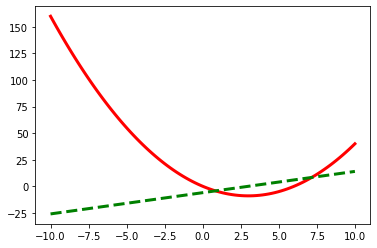

In [ ]:
fig = plt.figure()
ax = plt.axes()
x = np.linspace(-10, 10, 100)
plt.plot(x, x**2 - 6*x, color='Red', linewidth=3)
plt.plot(x, (2*x) - 6, color='Green', linestyle='dashed', linewidth=3)
plt.show()

The **gradient** is a generalization of the usual concept of derivative applied to a function in mulitple dimensions, e.g. $f(x_1,x_2)$. If we find the spots where the partial derivatives are both 0, then we have found local minima. For minimization problems, we often want the *global* optima rather than the local ones, and if certain properties hold, such as convexity, then we can say the local minima is the global minima. 


Our function F has multiple variables (w and b), so we can calculate the gradient to minimize. We take partial derivatives. Since we have that "max" component of our  function, we need to consider the two cases:
- Case 1: If $y_1(w \cdot x_i + b) \geq 1$. In this case, we get a 0, and the function simplifies to $F = \frac{1}{2}\|w\|$
- Case 2: If it's less than 1, in which case we have:  $F = \frac{1}{2}\|w\| + 1 - y_i(w \cdot x_i + b)$

In the first case, our partial derivatives are:

$$\frac{\partial F}{\partial w_i} = w_i$$

$$ \frac{\partial F}{\partial b} = 0 $$

In the second case:

$$\frac{\partial F}{\partial w_i} = w_i - y_i x_i$$

$$ \frac{\partial F}{\partial b} = -y_i $$



In [ ]:
def get_gradients(loss, w, x, y):
    if loss == 0:
        dw = w
        db = 0
    else:
        dw = w - np.dot(x,y)
        db = -y
    
    return dw, db

### Optional: Lagrange Multipliers

We are focusing on the easier maximum margin classifier case, where we assume that our data is linearly separable. If that is not the case, then we need to use some more complicated math. We will not go through thi in detail, but it is covered very well here: https://www.svm-tutorial.com/. 

We will just highlight some key points:
- If a point $x_i$ satisfies $\nabla f(x_i) = 0$ and the Hessian is positive-definite, then $x_i$ is a local minimum
- The Hessian is a matrix of second partial derivatives of the function. To verify that it is positive-definite, we can compute leading principal minors.
- If the function is convex, then the local minimum is also the global minimum

We are also not *just* solving a minimization problem - we also have to deal with constraints. For this we can use Lagrange multipliers. 
- If we need to minimize function f subject to an equality constraint g, then we look for points where $\nabla f(x,y) = \lambda \nabla g(x,y) $
- $\lambda$ is called the **Lagrange multiplier**
- We capture this in a formula: $L(x,y,\lambda) = f(x,y) - \lambda g(x,y)$
- Then take the gradient: $\nabla L(x,y,\lambda) = \nabla f(x,y) - \lambda \nabla g(x,y)$

That is all we will say about Lagrange multipliers.


### Optional: SVM vs LR

Both LR and SVM are supervised learning algorithms for classification problems. Both involve taking a probabilistic model and minimizing some cost associated with misclassification.

LR focuses on maximizing the probability of the data. The farther the data is from the separating hyperplane, the happier LR is.

SVM tries to find the separating hyperplane that maximizes the distance of the closest points to the margin (support vectors). If a point is not a support vector, then it doesn't matter.


## SVM Class

We now define the SVM class. The parameters include the number of iterations for which the algorithm runs and a learning rate, which helps smooth out the gradient update values.

In [ ]:
class MySVM:
    def __init__(self, num_iterations = 100, learning_rate = 1e-3):
        self.num_iterations = num_iterations
        self.learning_rate = learning_rate
    
    def fit(self, X, y):
        # Initialize the vector and intercept to 0 values
        dim = X.shape[1]
        self.w = np.zeros(dim)
        self.b = 0

        # Map the labels from {0,1} to {-1,1}
        y_new = np.where(y == 0, -1, 1)

        for i in range(self.num_iterations):
            for idx,x in enumerate(X):
                t = np.dot(x, self.w) + self.b
                loss = hinge_loss(y_new[idx], t)
                dw, db = get_gradients(loss, self.w, x, y_new[idx])
                self.w -= self.learning_rate * dw
                self.b -= self.learning_rate * db
        return

    def predict(self, X):
        y_hat = np.dot(X, self.w) + self.b
        pred = np.sign(y_hat)

        # Map back to {0,1}
        return np.where(pred == -1, 0, 1)


## Evaluation and Comparison

In [ ]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.svm import SVC

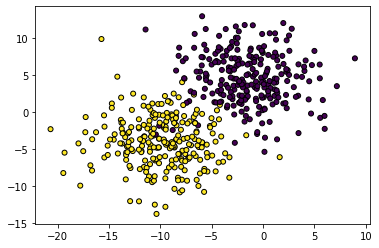

In [ ]:
X, y = datasets.make_blobs(n_samples=500, n_features=2, centers=2, cluster_std=3.5, random_state=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=1)

plt.scatter(X[:, 0], X[:, 1], marker="o", c=y, s=25, edgecolor="k")
plt.show()

In [ ]:
my_svm = MySVM()

my_svm.fit(X_train, y_train)

preds = my_svm.predict(X_test)

print(metrics.classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.96      0.96      0.96        50
           1       0.96      0.96      0.96        50

    accuracy                           0.96       100
   macro avg       0.96      0.96      0.96       100
weighted avg       0.96      0.96      0.96       100



In [ ]:
svm = SVC()

svm.fit(X_train, y_train)

preds2 = svm.predict(X_test)

print(metrics.classification_report(y_test, preds2))

              precision    recall  f1-score   support

           0       0.96      0.96      0.96        50
           1       0.96      0.96      0.96        50

    accuracy                           0.96       100
   macro avg       0.96      0.96      0.96       100
weighted avg       0.96      0.96      0.96       100

